# 1st iteration: dummy model

In [1]:
import pandas as pd
titanic = pd.read_csv('../../data/titanic/train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2]:
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Data quality check

### Missing values

In [3]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Duplicated rows

In [4]:
titanic.duplicated().sum()

0

### Basic exploration

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic.groupby(['Sex','Survived']).agg(count = ('Survived','count'))

count
Sex    Survived       
female 0            81
       1           233
male   0           468
       1           109

## Create the dummy model ("Train")

In [7]:
def my_dummy_model(sex): 
    if sex == 'female': 
        return 1
    elif sex == 'male':
        return 0

titanic['preds'] = [my_dummy_model(sex) for sex in titanic['Sex']]
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  preds  
0      0         A/5 21171   7.2500   NaN        S      0  
1      0          PC 17599  71.2833   C85        C      1  
2      0  STON/O2. 3101282   7.9250   NaN        S      1  
3      0            113803  53.1000  C123        S      1  
4      0            373450   8.0500   NaN        S      0

## Evaluate my model

Look at the two columns to compare:

In [8]:
error_check = titanic.filter(['Survived','preds']).assign(check = lambda x: x['Survived'] == x['preds'])
error_check.sample(10)

Survived  preds  check
865         1      1   True
162         0      0   True
282         0      0   True
453         1      0  False
66          1      1   True
784         0      0   True
791         0      0   True
111         0      1  False
610         0      1  False
275         1      1   True

In [9]:
#total number of correct answers: Where check is True
error_check['check'].sum()

701

In [10]:
#accuracy of the model is: sum of True answers divided by total number of survived
error_check['check'].sum() / error_check.shape[0]

0.7867564534231201

In [11]:
titanic.drop(columns=['preds'], inplace=True)

# 2nd iteration: creating train and test

## Split the dataset

In [12]:
from sklearn.model_selection import train_test_split

X = titanic.drop(columns=['Survived'])
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Short exploration

In [13]:
(
    X_train
    .assign(Survived = y_train)
    .groupby(['Sex','Survived'])
    .agg(count = ('Survived','count'))
    )

count
Sex    Survived       
female 0            59
       1           179
male   0           351
       1            79

Based on this quick analyisis, can apply the same model as before.

## Test the model

In [14]:
# Prediction if someone would have survived or not with the dummy model
X_train['preds'] = [my_dummy_model(sex) for sex in X_train['Sex']]
X_test['preds'] = [my_dummy_model(sex) for sex in X_test['Sex']]

Finding the accuracy for the train and test set:

In [15]:
# results train data:
(
    pd.DataFrame({
        'Survived':y_train,
        'preds':[my_dummy_model(sex) for sex in X_train['Sex']]
        })
    .assign(check = lambda x: x['Survived'] == x['preds'])['check']
    .sum()
) / len(y_train)

0.7934131736526946

In [16]:
# results test data:
acc_2nd = (
    pd.DataFrame({
        'Survived':y_test,
        'preds':[my_dummy_model(sex) for sex in X_test['Sex']]
        })
    .assign(check = lambda x: x['Survived'] == x['preds'])['check']
    .sum()
) / len(y_test)
acc_2nd

0.7668161434977578

# 3rd iteration: first scikit-learning model

Creating a decision tree. Use only the column Sex as a predictor:

In [17]:
X = titanic.filter(['Sex'])
y = titanic.filter(['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Pre process the data

Transforming a categorical variable into a numeric variable

With ```pandas```

In [18]:
pd.get_dummies(X_train).head()

Sex_female  Sex_male
521           0         1
753           0         1
643           0         1
332           0         1
743           0         1

With ```sklearn```

In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder (drop='first', sparse=False)
enc.fit(X_train)

OneHotEncoder(drop='first', sparse=False)

In [20]:
enc.get_feature_names_out()[0]

'Sex_male'

In [21]:
X_train_enc = enc.transform(X_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=list(enc.get_feature_names_out()))
X_train_enc.head()

Sex_male
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0

## Train the model

In [22]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_enc, y_train)

DecisionTreeClassifier()

### Visualise the model

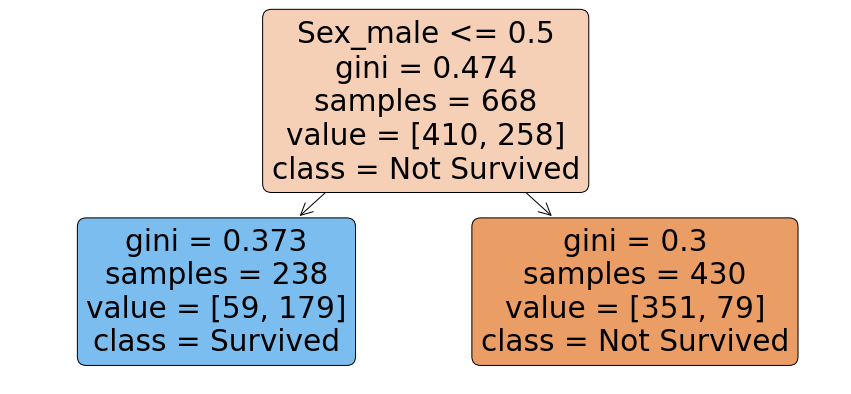

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 7))
plot_tree(
    tree, 
    filled=True,
    rounded=True,
    class_names=['Not Survived', 'Survived'],
    feature_names=X_train_enc.columns
    );

## Test our model

### Check the metrics on train

In [24]:
# Check the accuracy:
from sklearn.metrics import accuracy_score
preds = tree.predict(X_train_enc)
accuracy_score(preds, y_train)

0.7934131736526946

The same accuracy we got on the 2nd iteration, where we have created a dummy model with our own function (accuracy 2nd iteration was 0.7934131736526946)

### Metrics on test

In [25]:
# 1st need to transform these metrics
X_test_enc = pd.DataFrame(enc.transform(X_test), columns=list(enc.get_feature_names_out()))

# predict:
preds = tree.predict(X_test_enc)
acc_3rd = accuracy_score(preds, y_test)
acc_3rd

0.7668161434977578

Same results as we got on the 2nd iteration: 0.7313432835820896

#### Confusion matrix

Another way to visualise our errors is to use a confusion matrix:

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


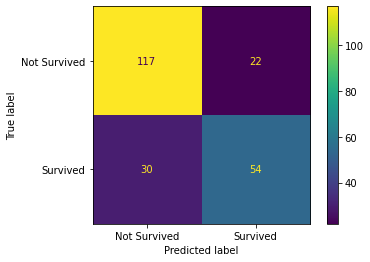

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree, X_test_enc, y_test, display_labels=['Not Survived', 'Survived']);

Observations:

* Total Not Survived: 117 + 22 = 139.
* Total Survived: 30 + 54 = 84.
* Not Survived correctly classified: 117 (117 / 139 = 0.84) -> 84% over the total not survived people).
* Survived correclty classified: 33 (33 / 51 = 0.65) -> 65% over the total survived people).

# 4th iteration: more features + missing values preprocessing

Train the model with more variables using the decision trees.   

## Feature selection 

Select the variables which are important to predict if someone has survived or not to this disaster:

In [27]:
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [28]:
X = titanic.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId', 'Survived'])
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
768       3    male   NaN      1      0  24.1500        Q
387       2  female  36.0      0      0  13.0000        S
823       3  female  27.0      0      1  12.4750        S
778       3    male   NaN      0      0   7.7375        Q
157       3    male  30.0      0      0   8.0500        S

## Preprocess

### Missing values

In [29]:
X_train.isna().sum()

Pclass        0
Sex           0
Age         142
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Column "age" includes missing values.

Numerical variables:

* Age: Age in years
* SibSp: # of siblings / spouses aboard the Titanic
* Parch : # of parents / children aboard the Titanic
* Fare : Passenger fare

Define numeric columns and using SimpleImputer fill the missing data with median of available dataset.

In [30]:
num_col = ['Age','SibSp','Parch','Fare']

from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(strategy='median')

X_train[num_col] = imp_num.fit_transform(X_train[num_col])
X_test[num_col] = imp_num.fit_transform(X_test[num_col])
X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

#### Embarked missing values


Categorical variables: 

* Pclass : 	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Sex
* Embarked : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Define categorical columns and using SimpleImputer strategy "most_frwquent" fill in the missing values with most common Port of Embarkation

In [31]:
cat_col = ['Pclass','Sex','Embarked']

imp_cat=SimpleImputer(strategy='most_frequent')

X_train[cat_col] = imp_cat.fit_transform(X_train[cat_col])
X_test[cat_col] = imp_cat.fit_transform(X_test[cat_col])
X_train.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Encoding variables

In [32]:
enc = OneHotEncoder(
    drop='first',
    sparse=False
    )
X_train_enc = enc.fit_transform(X_train[cat_col])
X_test_enc = enc.transform(X_test[cat_col])

Modify X_train

In [33]:
X_train_enc = pd.DataFrame(X_train_enc, columns=list(enc.get_feature_names_out()), index=X_train.index)

X_train = pd.concat([X_train, X_train_enc], axis=1, ignore_index=False).drop(columns=cat_col)
X_train.head()

Age  SibSp  Parch     Fare  Pclass_2  Pclass_3  Sex_male  Embarked_Q  \
768  29.0    1.0    0.0  24.1500       0.0       1.0       1.0         1.0   
387  36.0    0.0    0.0  13.0000       1.0       0.0       0.0         0.0   
823  27.0    0.0    1.0  12.4750       0.0       1.0       0.0         0.0   
778  29.0    0.0    0.0   7.7375       0.0       1.0       1.0         1.0   
157  30.0    0.0    0.0   8.0500       0.0       1.0       1.0         0.0   

     Embarked_S  
768         0.0  
387         1.0  
823         1.0  
778         0.0  
157         1.0

Modify X_test

In [34]:
X_test_enc = pd.DataFrame(X_test_enc, columns=list(enc.get_feature_names_out()), index=X_test.index)
X_test_enc
X_test = pd.concat([X_test, X_test_enc], axis=1, ignore_index=False).drop(columns=cat_col)
X_test.head()

Age  SibSp  Parch      Fare  Pclass_2  Pclass_3  Sex_male  Embarked_Q  \
350  23.0    0.0    0.0    9.2250       0.0       1.0       1.0         0.0   
176  25.5    3.0    1.0   25.4667       0.0       1.0       1.0         0.0   
723  50.0    0.0    0.0   13.0000       1.0       0.0       1.0         0.0   
404  20.0    0.0    0.0    8.6625       0.0       1.0       0.0         0.0   
306  25.5    0.0    0.0  110.8833       0.0       0.0       0.0         0.0   

     Embarked_S  
350         1.0  
176         1.0  
723         1.0  
404         1.0  
306         0.0

## Decision tree

##### Training model

In [35]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

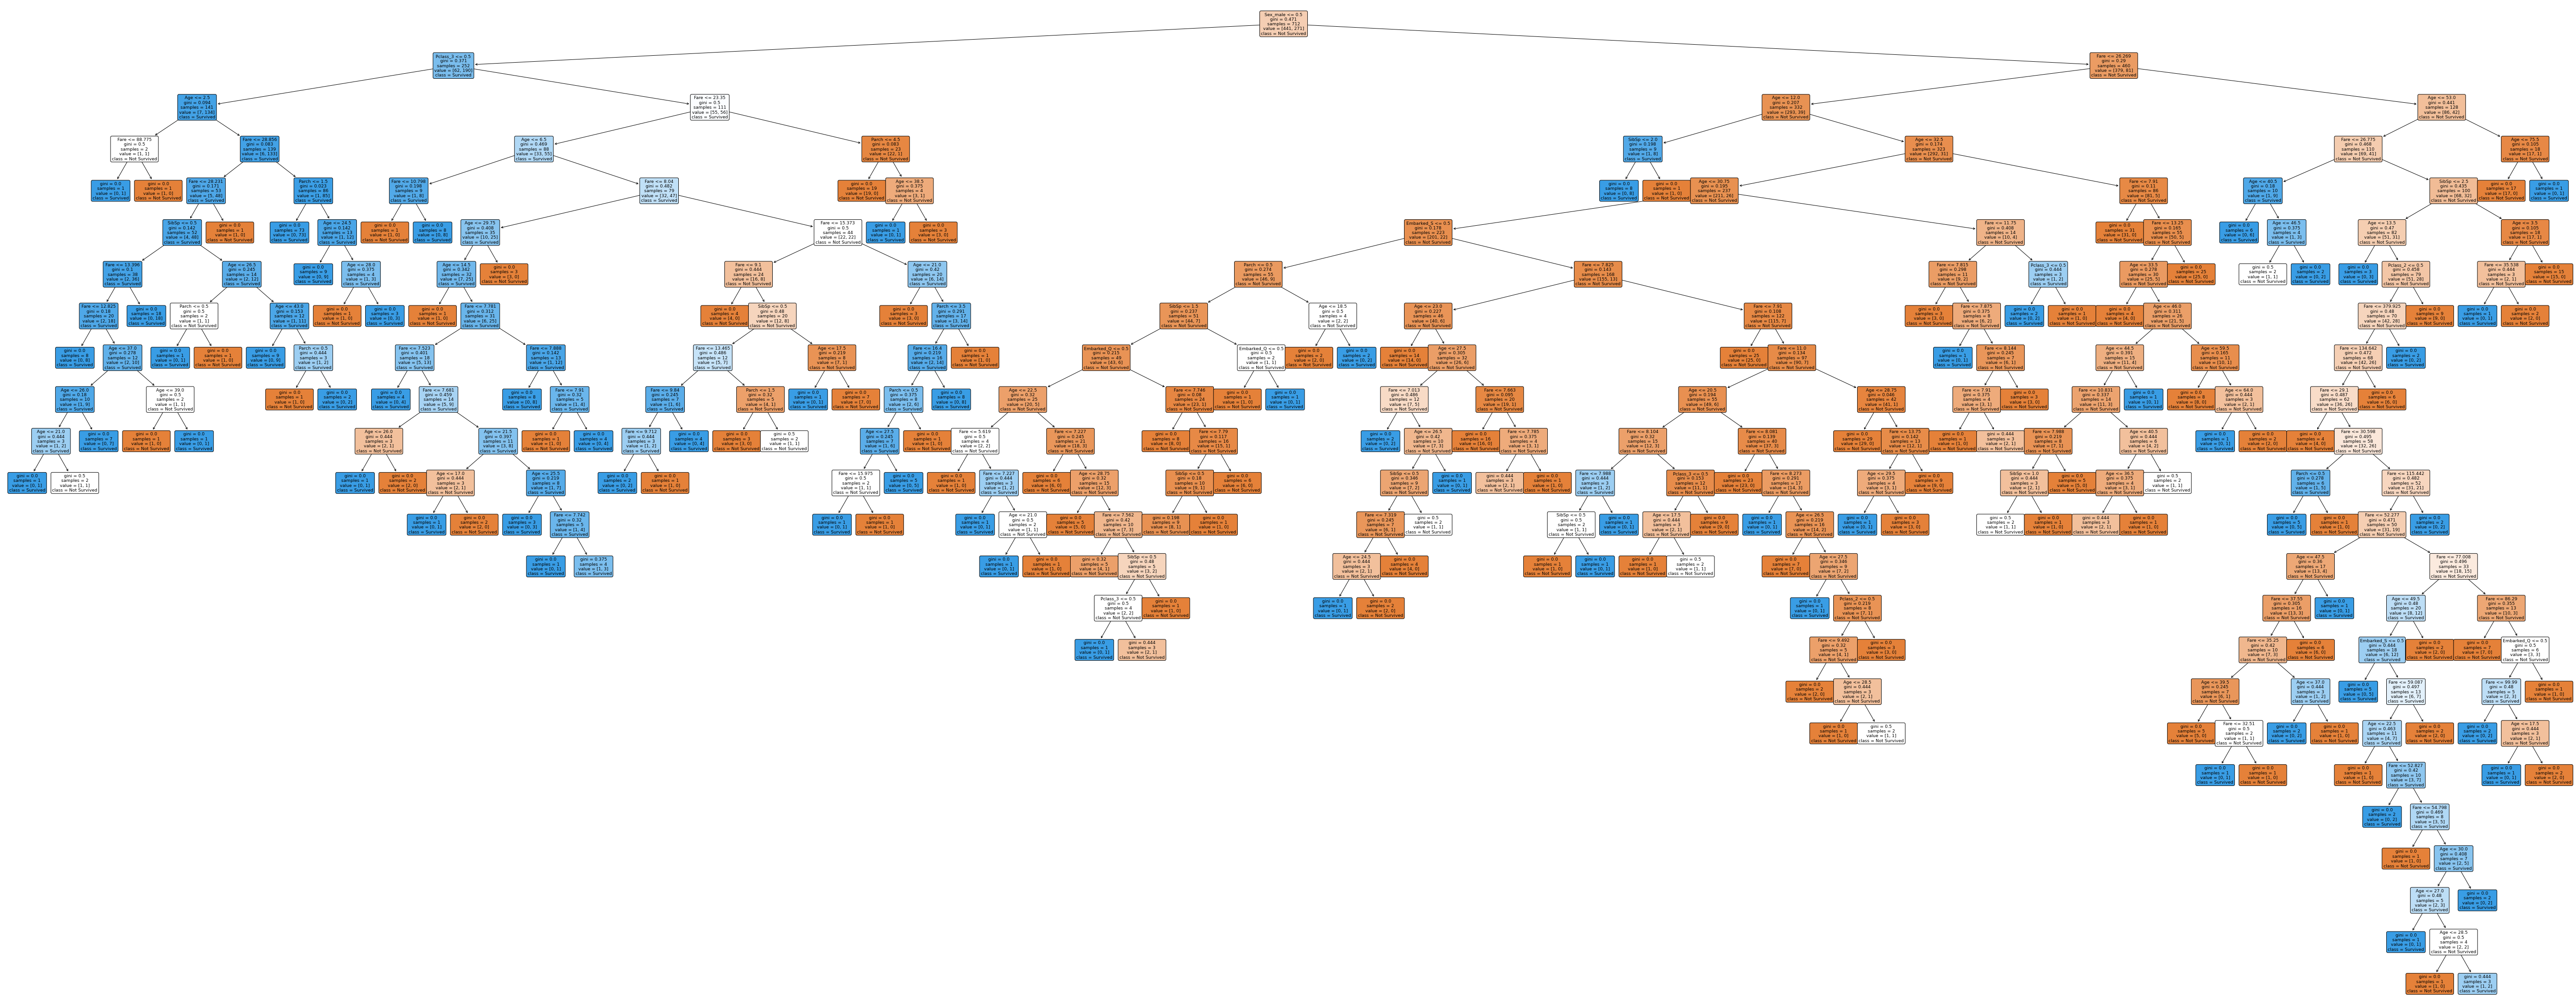

In [36]:
plt.figure(figsize=(100, 40))
plot_tree(
    tree,
    filled=True, 
    rounded=True, 
    class_names=['Not Survived', 'Survived'], 
    feature_names=X_train.columns
    );

##### Test own model

In [37]:
#accuracy in train set:
preds=tree.predict(X_train)
accuracy_score(preds, y_train)

0.9775280898876404

In [38]:
#accuracy in test set:
preds = tree.predict(X_test)
acc_4th = accuracy_score(preds, y_test)
acc_4th

0.7653631284916201

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


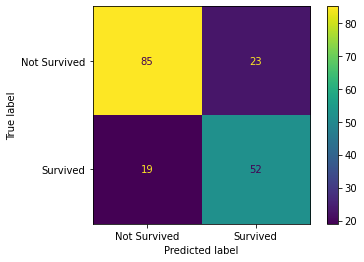

In [39]:
plot_confusion_matrix(tree, X_test, y_test, display_labels=['Not Survived', 'Survived']);

# 5th iteration: prunning the tree

Train the model with a max depth of 3

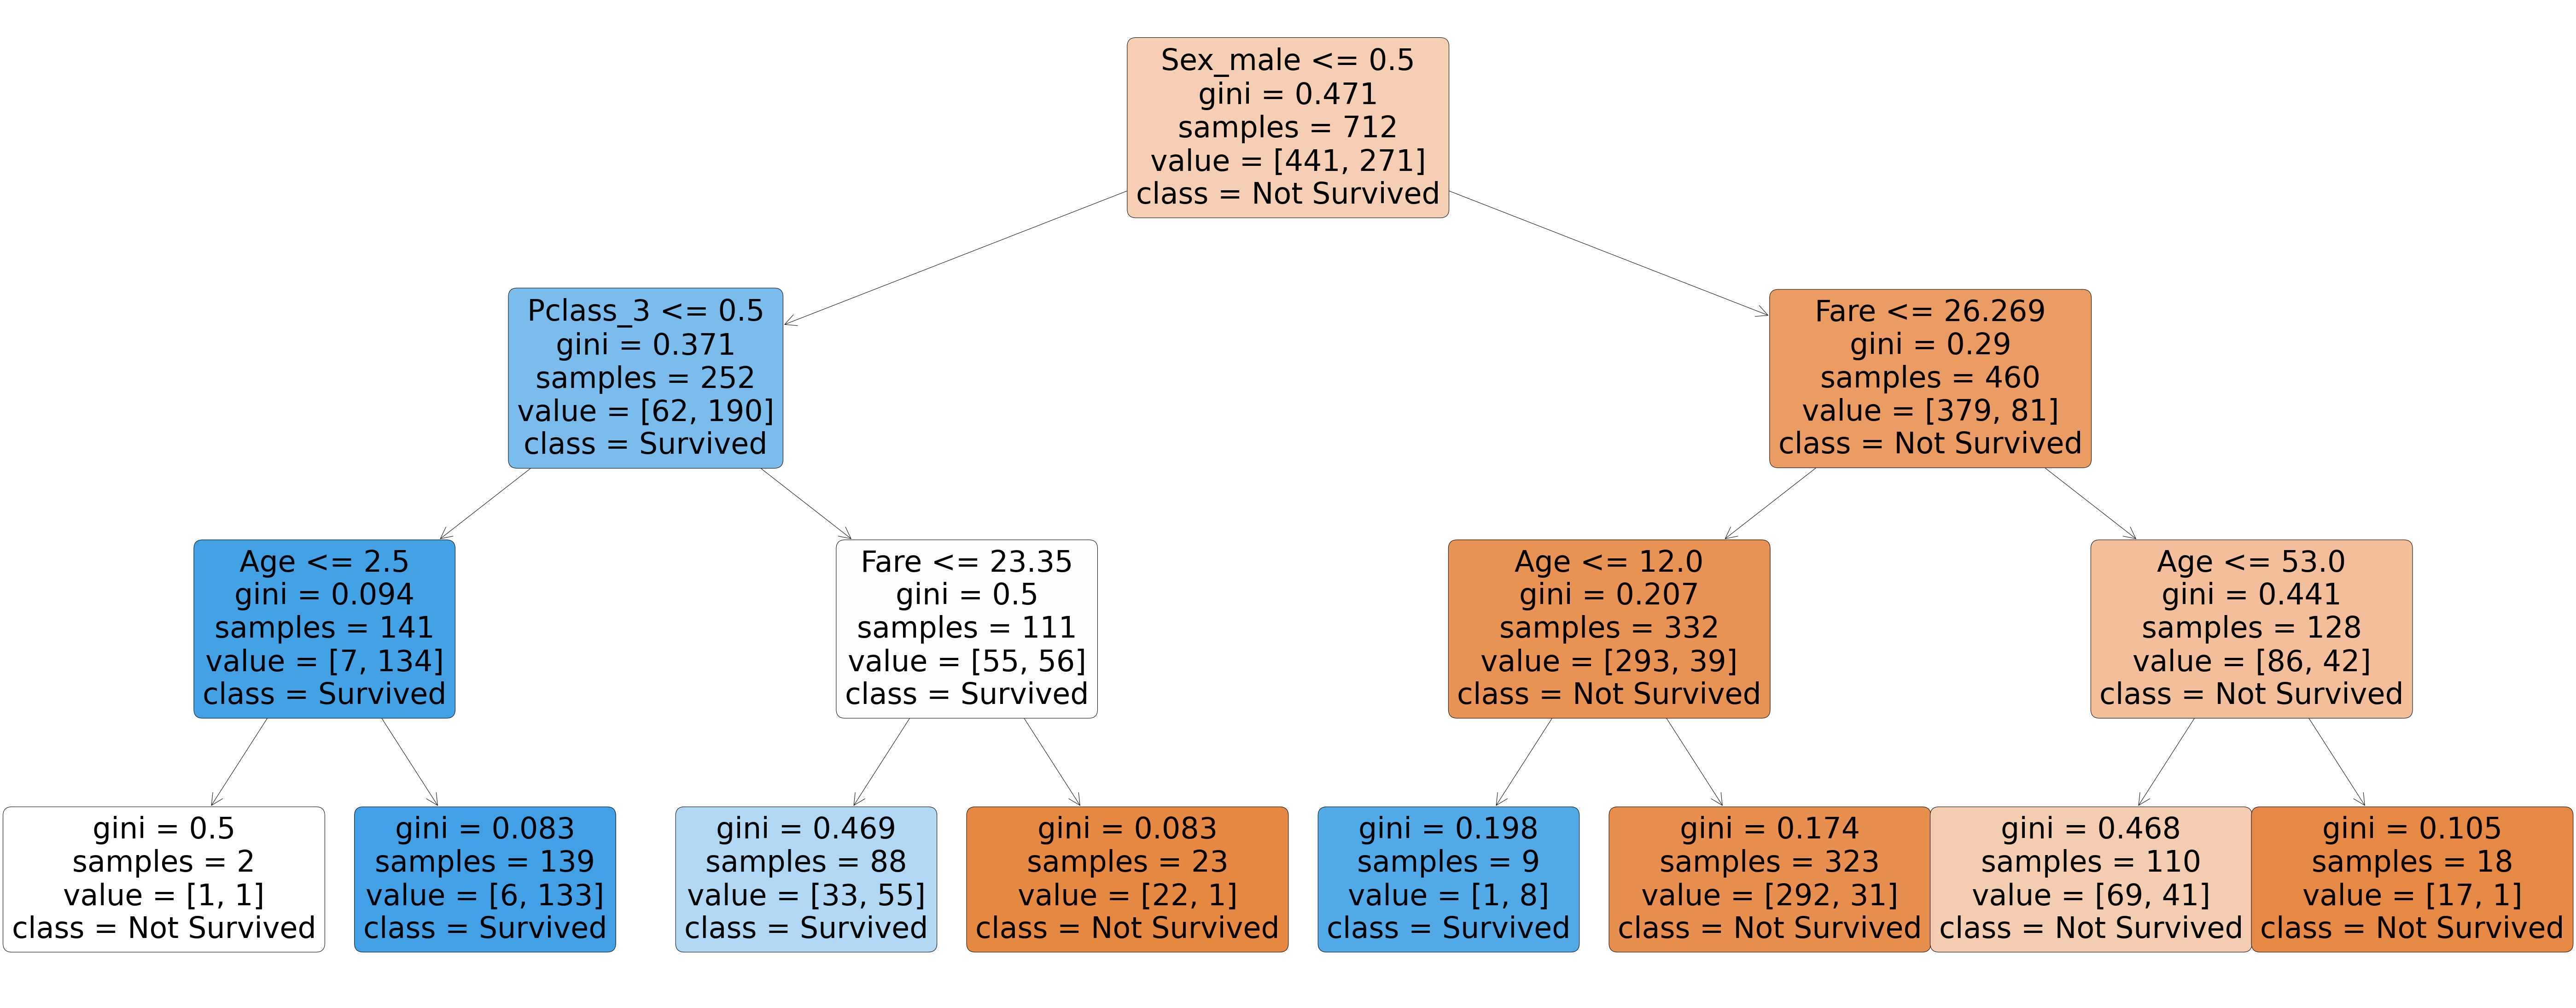

In [40]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)
plt.figure(figsize=(100, 40))
plot_tree(
    tree, 
    filled=True, 
    rounded=True,
    class_names=['Not Survived', 'Survived'],
    feature_names=X_train.columns
    );

### Test own model

In [41]:
# accuracy train set:
preds=tree.predict(X_train)
accuracy_score(preds, y_train)

0.8384831460674157

In [42]:
# accuracy test set:
preds = tree.predict(X_test)
acc_4th = accuracy_score(preds, y_test)
acc_4th

0.7597765363128491

# 6th iteration: scikit-learn pipeline

In [43]:
X = titanic.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId', 'Survived'])
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.head()

Pclass   Sex   Age  SibSp  Parch      Fare Embarked
521       3  male  22.0      0      0    7.8958        S
753       3  male  23.0      0      0    7.8958        S
643       3  male   NaN      0      0   56.4958        S
332       1  male  38.0      0      1  153.4625        S
743       3  male  24.0      1      0   16.1000        S

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])

In [45]:
from sklearn.compose import ColumnTransformer

num_col = ['Age','Fare','SibSp','Parch']
cat_col = ['Pclass','Sex','Embarked']

full_processor = ColumnTransformer(transformers = [
    ('number', numeric_pipeline, num_col),
    ('category', categorical_pipeline, cat_col)
])

pd.DataFrame(full_processor.fit_transform(X_train))

0         1      2         3    4    5    6    7    8
0    0.271174  0.015412  0.000  0.000000  0.0  1.0  1.0  0.0  1.0
1    0.283740  0.015412  0.000  0.000000  0.0  1.0  1.0  0.0  1.0
2    0.359135  0.110272  0.000  0.000000  0.0  1.0  1.0  0.0  1.0
3    0.472229  0.299539  0.000  0.166667  0.0  0.0  1.0  0.0  1.0
4    0.296306  0.031425  0.125  0.000000  0.0  1.0  1.0  0.0  1.0
..        ...       ...    ...       ...  ...  ...  ...  ...  ...
663  0.233476  0.051302  0.000  0.333333  0.0  0.0  0.0  0.0  1.0
664  0.359135  0.050749  0.125  0.000000  1.0  0.0  0.0  0.0  1.0
665  0.359135  0.054107  0.125  0.000000  1.0  0.0  1.0  0.0  0.0
666  0.019854  0.050749  0.125  0.166667  1.0  0.0  1.0  0.0  1.0
667  0.359135  0.038972  0.125  0.000000  0.0  1.0  1.0  0.0  1.0

[668 rows x 9 columns]

In [46]:
# Adding the model into scikit pipeline:

tree_pipeline = Pipeline(steps = [
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(drop='first',
          

### Test the accuracy of sklearn pipeline

In [47]:
accuracy_score(tree_pipeline.predict(X_train), y_train)

0.9790419161676647

In [48]:
preds = tree_pipeline.predict(X_test)
acc_5th = accuracy_score(preds, y_test)
acc_5th

0.7757847533632287

C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


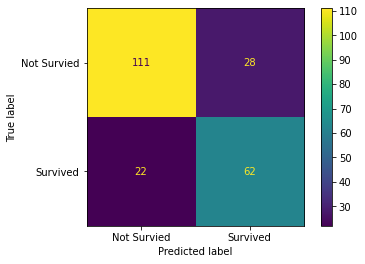

In [49]:
plot_confusion_matrix(tree_pipeline, X_test, y_test, display_labels=['Not Survied', 'Survived']);

# 7th iteration: Manual model tunning

## Preprocess (nice and clean code)

In [50]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])

# automating the column selection
num_col = ['Age','Fare','SibSp','Parch']
cat_col = ['Pclass','Sex','Embarked']
full_processor = ColumnTransformer(transformers = [
    ('number', numeric_pipeline, num_col),
    ('category', categorical_pipeline, cat_col)
])

## Tunning our model

In [51]:
# adding the model in our pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier(max_depth=4))
])
# fit our model to the train
tree_pipeline.fit(X_train, y_train)
accuracy_score(tree_pipeline.predict(X_train), y_train)

0.8353293413173652

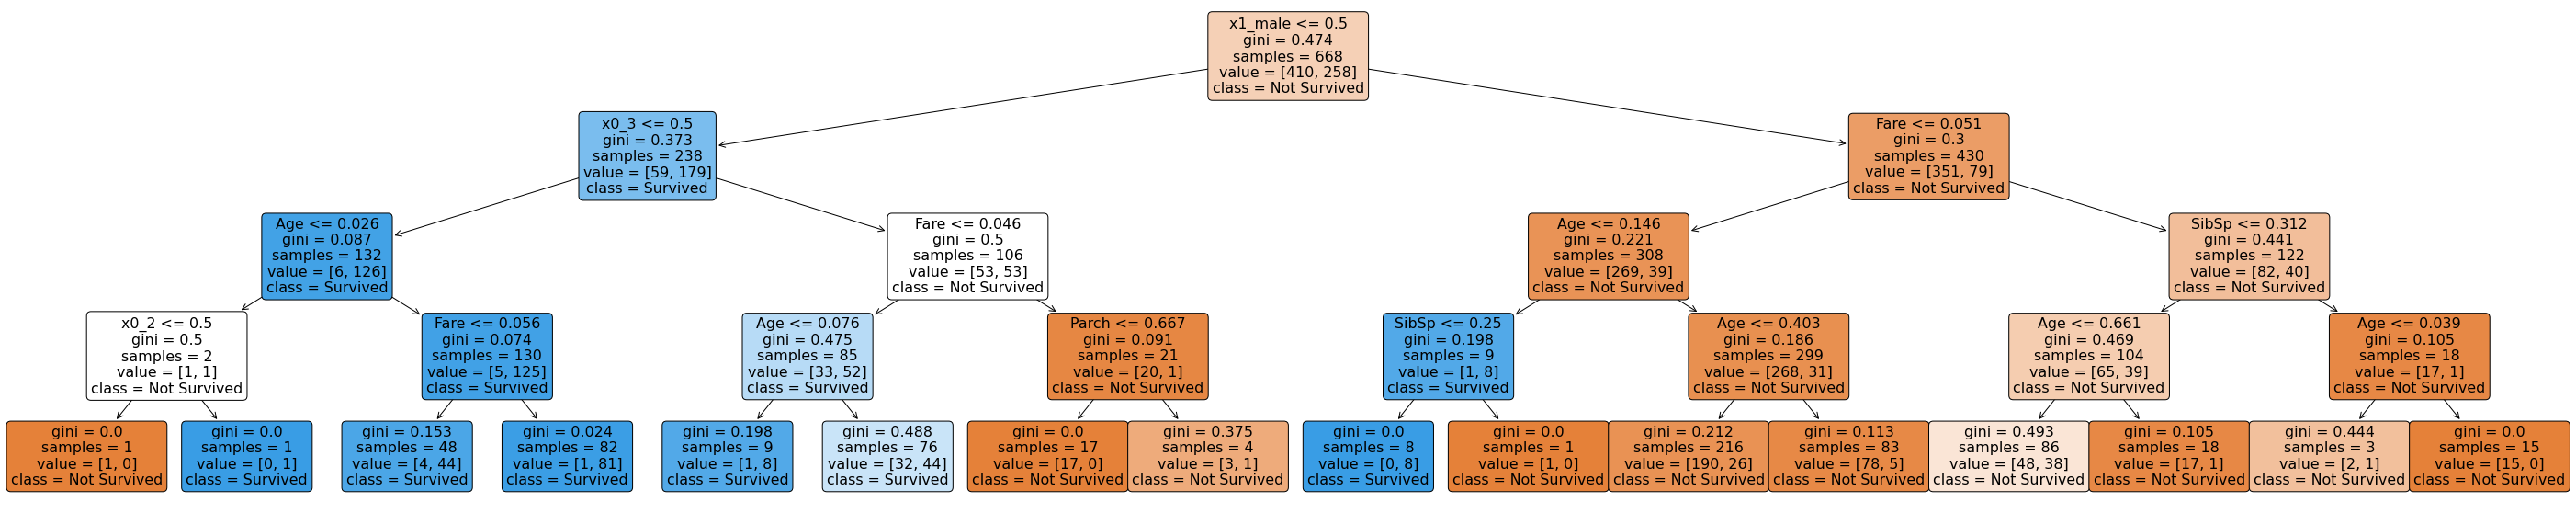

In [52]:
# get column names
col_names = num_col.copy()
col_names.extend(
    tree_pipeline.named_steps['preprocess'].transformers_[1][1].named_steps['one-hot'].get_feature_names_out()
)

plt.figure(figsize=(50, 10))
plot_tree(
    tree_pipeline['model'],
    filled=True,
    rounded=True,
    feature_names=col_names,
    class_names=['Not Survived', 'Survived']
    );

In [53]:
preds = tree_pipeline.predict(X_test)
acc_6th = accuracy_score(preds, y_test)
acc_6th

0.7892376681614349

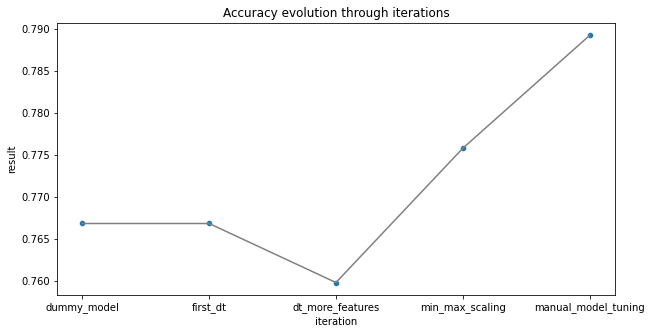

In [54]:
import seaborn as sns 

# Check if the model has improved:
plt.subplots(figsize=(10, 5))
results = pd.DataFrame({
    'iteration': ['dummy_model', 'first_dt', 'dt_more_features', 'min_max_scaling', 'manual_model_tuning'],
    'result': [acc_2nd, acc_3rd, acc_4th, acc_5th, acc_6th]
})
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');

# 8th iteration: Auto model tunning + Cross Validation

In [55]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])
# automating the column selection
cat_col = ['Pclass','Sex','Embarked']
num_col = ['Age','Fare','SibSp','Parch']
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, num_col), 
    ('category', categorical_pipeline, cat_col)
])

# adding the model in our pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])
# automating the search of the different parameters for our model
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__max_depth': range(1, 8),
    'model__min_samples_leaf': range(1, 10),
    'model__min_samples_split': range(2, 10),
    'model__criterion':['gini','entropy']
    }
search = GridSearchCV(
    tree_pipeline, 
    param_grid, 
    cv=15,
    scoring='accuracy', 
    verbose=1, 
    refit=True, 
    n_jobs=-1
    )
# fit our model to the train
_ = search.fit(X_train, y_train)

Fitting 15 folds for each of 1008 candidates, totalling 15120 fits


In [56]:
search.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 2}

In [57]:
accuracy_score(search.predict(X_train), y_train)

0.8592814371257484

In [58]:
# accuracy of the test:
acc_7th = accuracy_score(search.predict(X_test), y_test)
acc_7th

0.8026905829596412

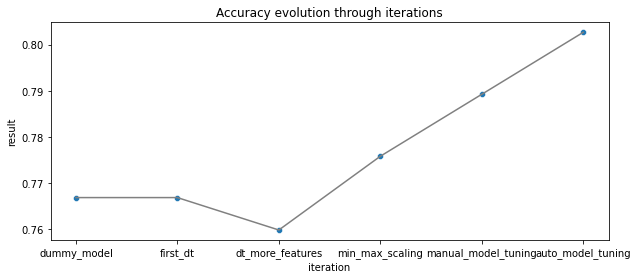

In [59]:
plt.figure(figsize=(10, 4))
results = results.append({'iteration':'auto_model_tuning', 'result': acc_7th}, ignore_index=True)
sns.lineplot(data=results, x='iteration', y='result', color='grey')
sns.scatterplot(data=results, x='iteration', y='result')
plt.title('Accuracy evolution through iterations');

# 9th iteration: get status from name

In [60]:
X = titanic.drop(columns=['Ticket','Cabin','PassengerId','Survived'])
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vect_name = vectorizer.fit_transform(X_train['Name'])
(
pd.DataFrame(
    vect_name.toarray(),
    columns=vectorizer.get_feature_names_out()
    )
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head()
)

index    0
0       mr  422
1     miss  144
2      mrs  106
3  william   52
4     john   39

Using clean code

In [62]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])
# extract tittle from the name
status_engineering = Pipeline(steps=[
    ('status', CountVectorizer(max_features=7))
])
# automating the column selection
cat_col = ['Pclass','Sex','Embarked']
num_col = ['Age','Fare','SibSp','Parch']
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, num_col), 
    ('category', categorical_pipeline, cat_col),
    ('engineering', status_engineering, 'Name')
])

# adding the model in our pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())
])
# automating the search of the different parameters for our model
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__max_depth': range(1, 8),
    'model__min_samples_leaf': range(1, 10),
    'model__min_samples_split': range(2, 10),
    'model__criterion':['gini','entropy']
    }
search = GridSearchCV(
    tree_pipeline, 
    param_grid,
    cv=15, 
    scoring='accuracy',
    verbose=1,
    refit=True, 
    n_jobs=-1
    )
# fit our model to the train
_ = search.fit(X_train, y_train)

Fitting 15 folds for each of 1008 candidates, totalling 15120 fits


In [63]:
accuracy_score(search.predict(X_train), y_train)

0.8679775280898876

In [64]:
acc_8th = accuracy_score(search.predict(X_test), y_test)
acc_8th

0.776536312849162

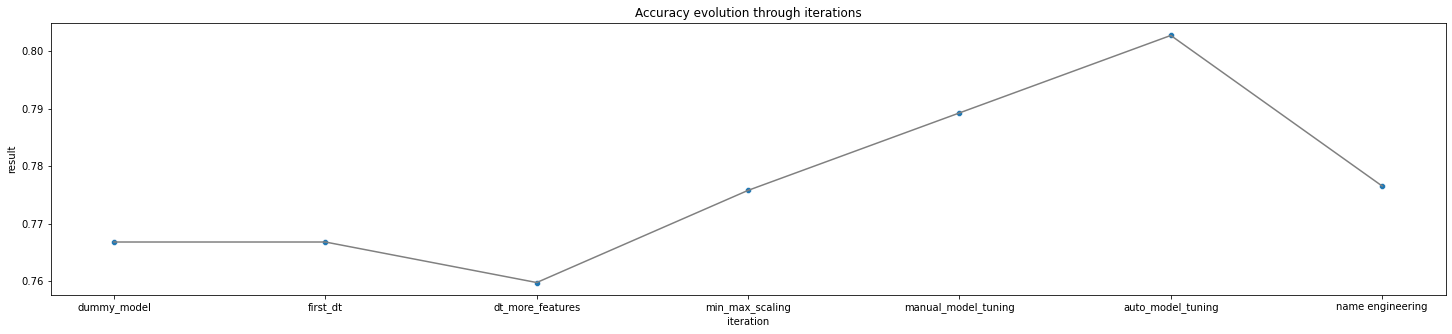

In [65]:
def plot_iterations_evolution(new_iteration_name, new_acc):
    global results
    results = results.append(
        {
            'iteration':new_iteration_name,
            'result': new_acc
        }, 
        ignore_index=True)
    plt.subplots(figsize=(25, 5))
    sns.lineplot(data=results, x='iteration', y='result', color='grey')
    sns.scatterplot(data=results, x='iteration', y='result')
    plt.title('Accuracy evolution through iterations')
    plt.show()

plot_iterations_evolution('name engineering', acc_8th)

## EXTRA: understanding feature importance in our model

In [66]:
cat_enc_col = (search
              .best_estimator_
              .named_steps['preprocess']
              .transformers_[1][1]
                .named_steps['one-hot']
                .get_feature_names_out()
                .tolist())
name_new_col = (search
                .best_estimator_
                .named_steps['preprocess']
                .transformers_[2][1]
                .get_feature_names_out()
                .tolist())

pd.DataFrame({
    'cols': num_col + cat_enc_col + name_new_col,
    'importance': search.best_estimator_.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

cols  importance
6   x1_male    0.538485
1      Fare    0.181494
5      x0_3    0.122275
0       Age    0.064699
11   master    0.062532
2     SibSp    0.020571
3     Parch    0.003594
12     miss    0.002260
9     henry    0.002063
8      x2_S    0.002027
4      x0_2    0.000000
7      x2_Q    0.000000
10     john    0.000000
13       mr    0.000000
14      mrs    0.000000
15  william    0.000000

# 10th iteration: feature selection and error analysis

Updating sklearn pipeline with ```SelectFromModel``` for feature selection

In [67]:
# numerical and categorical pipeline
numeric_pipeline = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(drop='first', sparse=False))
])
# extract title from the name
status_egnineering = Pipeline(steps=[
    # will let our decision tree to select which are the important features
    ('status', CountVectorizer(max_features=40))
])
# automating the column selection
cat_col = ['Pclass','Sex','Embarked']
num_col = ['Age','Fare','SibSp','Parch']
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, num_col), 
    ('category', categorical_pipeline, cat_col),
    ('engineering', status_egnineering, 'Name')
])
# defining the parameters of our model based on previous cv
# (later on we can run again a gridsearch, but we want to speed up this process)
param_grid = {
    'criterion': 'entropy',
    'max_depth': 6,
    'min_samples_leaf': 5,
    'min_samples_split': 2
    }

from sklearn.feature_selection import SelectFromModel
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
    ('model', DecisionTreeClassifier(**param_grid))
])

_ = tree_pipeline.fit(X_train, y_train)
accuracy_score(tree_pipeline.predict(X_train), y_train)

0.8623595505617978

### Undestanding the model

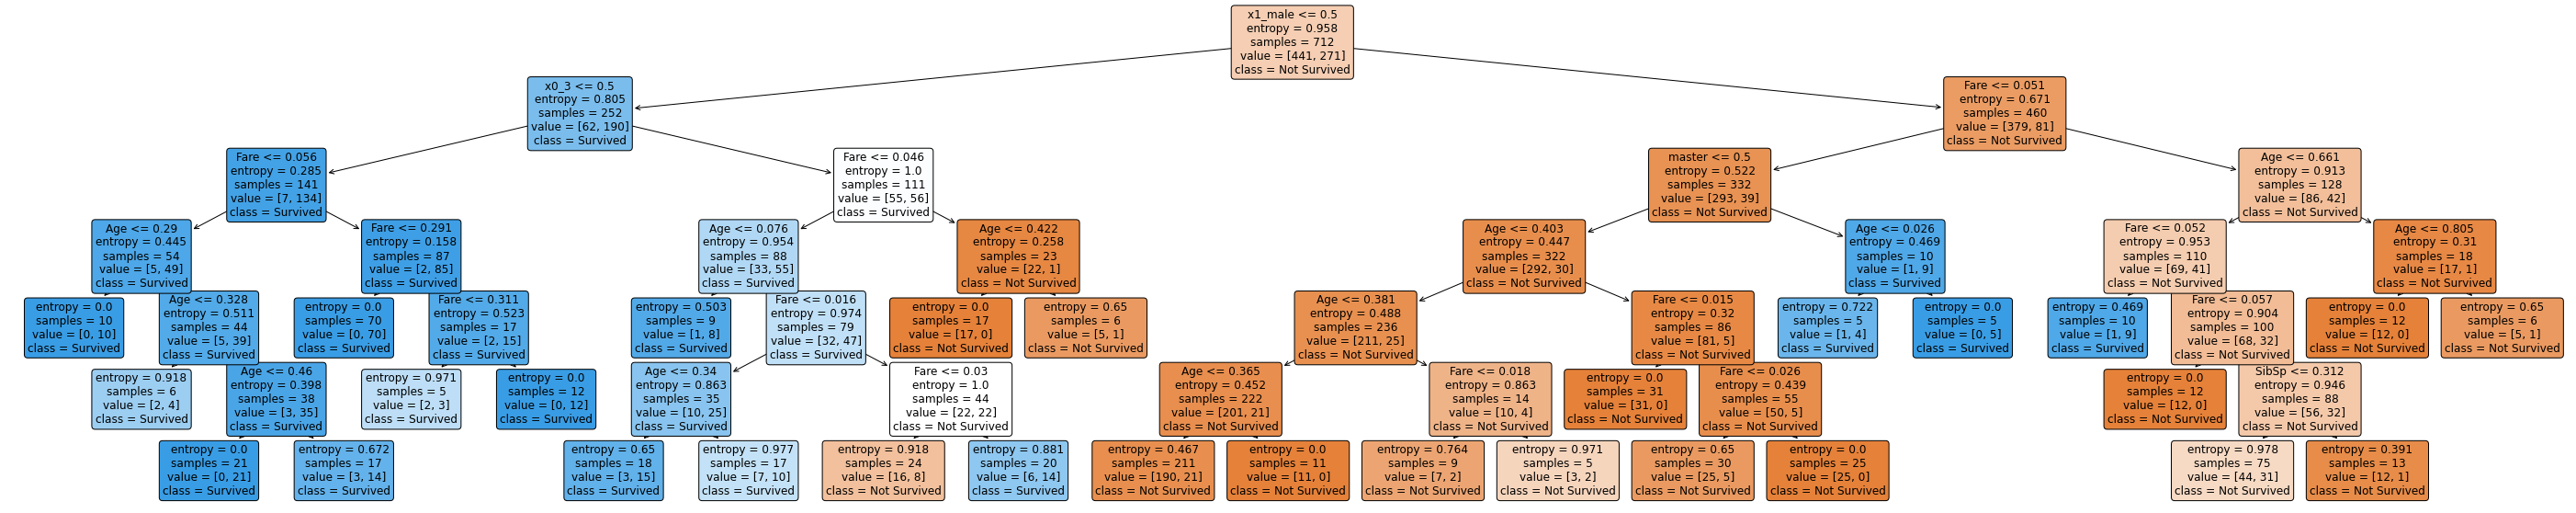

In [68]:
cat_enc_col = (tree_pipeline
    .named_steps['preprocess']
    .transformers_[1][1]
    .named_steps['one-hot']
    .get_feature_names_out()
    .tolist()
    )
name_new_col = (tree_pipeline
    .named_steps['preprocess']
    .transformers_[2][1]
    .get_feature_names_out()
    .tolist()
    )

preprocess_col = num_col + cat_enc_col + name_new_col
selected_cols_pos = tree_pipeline.named_steps['feature_selection'].get_feature_names_out()
feature_names = [preprocess_col[int(col_name.replace('x',''))] for col_name in selected_cols_pos]

plt.figure(figsize=(50,10))
plot_tree(
    tree_pipeline['model'],
    filled=True,
    rounded=True,
    feature_names=feature_names,
    class_names = ['Not Survived', 'Survived']
    );

In [69]:
# Looking at the feature importance

pd.DataFrame({
    'cols': feature_names,
    'importance': tree_pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

cols  importance
4  x1_male    0.469421
1     Fare    0.229182
3     x0_3    0.142090
0      Age    0.078267
5   master    0.067937
2    SibSp    0.013103

### Testing the model

In [70]:
acc_10th = accuracy_score(search.predict(X_test), y_test)
acc_10th

0.776536312849162

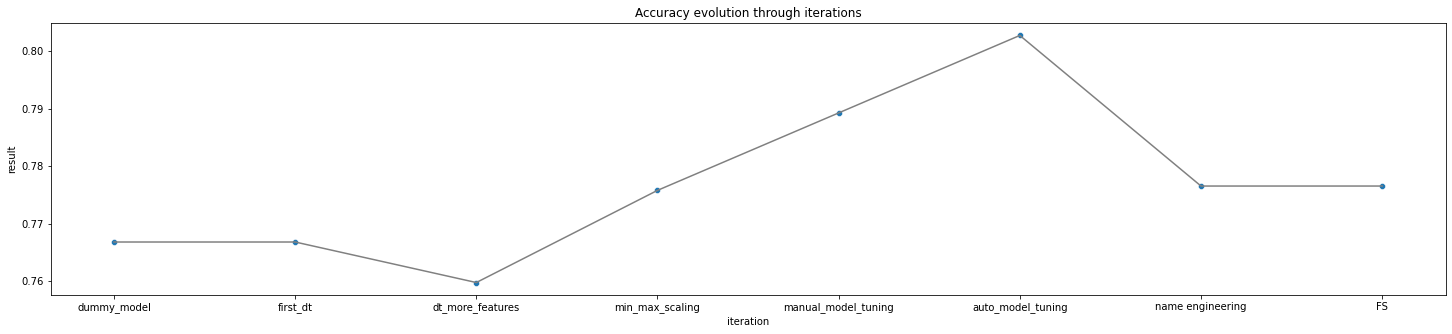

In [71]:
plot_iterations_evolution('FS', acc_10th)

## Error analysis

Accuracy: 0.7988826815642458


C:\Users\akbar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


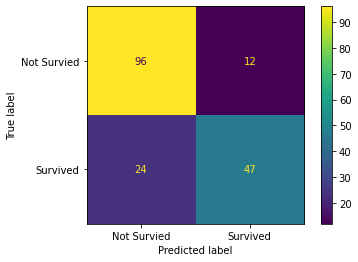

In [72]:
from sklearn.metrics import confusion_matrix

def model_check(y_true, y_preds, model):
    print('Accuracy:', accuracy_score(y_true, y_preds))
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Survied', 'Survived']);
    return tn, fp, fn, tp
tn, fp, fn, tp = model_check(y_test, tree_pipeline.predict(X_test), tree_pipeline)

In [73]:
47 / (24+47)

0.6619718309859155

In [74]:
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score
print(f"""
    Accuracy: {accuracy_score(tree_pipeline.predict(X_test), y_test)}
    Recall/Sensitivity: {recall_score(tree_pipeline.predict(X_test), y_test)}
    Precision (True Positive Rate): {precision_score(tree_pipeline.predict(X_test), y_test)}
    Specifity (False Positive Rate): {tn / (tn+fp)}
    F Score: {f1_score(tree_pipeline.predict(X_test), y_test)}
    Kappa: {cohen_kappa_score(tree_pipeline.predict(X_test), y_test)}
""")


    Accuracy: 0.7988826815642458
    Recall/Sensitivity: 0.7966101694915254
    Precision (True Positive Rate): 0.6619718309859155
    Specifity (False Positive Rate): 0.8888888888888888
    F Score: 0.7230769230769231
    Kappa: 0.5672844480257857



#### Understanding where the errors are commoing from

Our main problem is on the people that has survived, but in reality we are predicting them as not survived. Let's do a further exploration on the survival group:

In [75]:
X_train_preds = X_train.copy()

X_train_errors = (
    X_train_preds
    .assign(
        preds = tree_pipeline.predict(X_train),
        true = y_train
    )
    .query('true == 1')
)
X_train_errors

Pclass                                               Name     Sex   Age  \
387       2                                   Buss, Miss. Kate  female  36.0   
823       3                                 Moor, Mrs. (Beila)  female  27.0   
740       1                        Hawksford, Mr. Walter James    male   NaN   
345       2                      Brown, Miss. Amelia "Mildred"  female  24.0   
318       1                           Wick, Miss. Mary Natalie  female  31.0   
..      ...                                                ...     ...   ...   
828       3                       McCormack, Mr. Thomas Joseph    male   NaN   
85        3  Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...  female  33.0   
136       1                       Newsom, Miss. Helen Monypeny  female  19.0   
133       2      Weisz, Mrs. Leopold (Mathilde Francoise Pede)  female  29.0   
340       2                     Navratil, Master. Edmond Roger    male   2.0   

     SibSp  Parch      Fare Embarked  preds  true  
387      0      0   13.0000        S      1     1  
823      0      1   12.4750        S      0     1  
740      0      0   30.0000        S      0     1  
345      0      0   13.0000        S      1     1  
318      0      2  164.8667        S      1     1  
..     ...    ...       ...      ...    ...   ...  
828      0      0    7.7500        Q      0     1  
85       3      0   15.8500        S      1     1  
136      0      2   26.2833        S      1     1  
133      1      0   26.0000        S      1     1  
340      1      1   26.0000        S      1     1  

[271 rows x 10 columns]

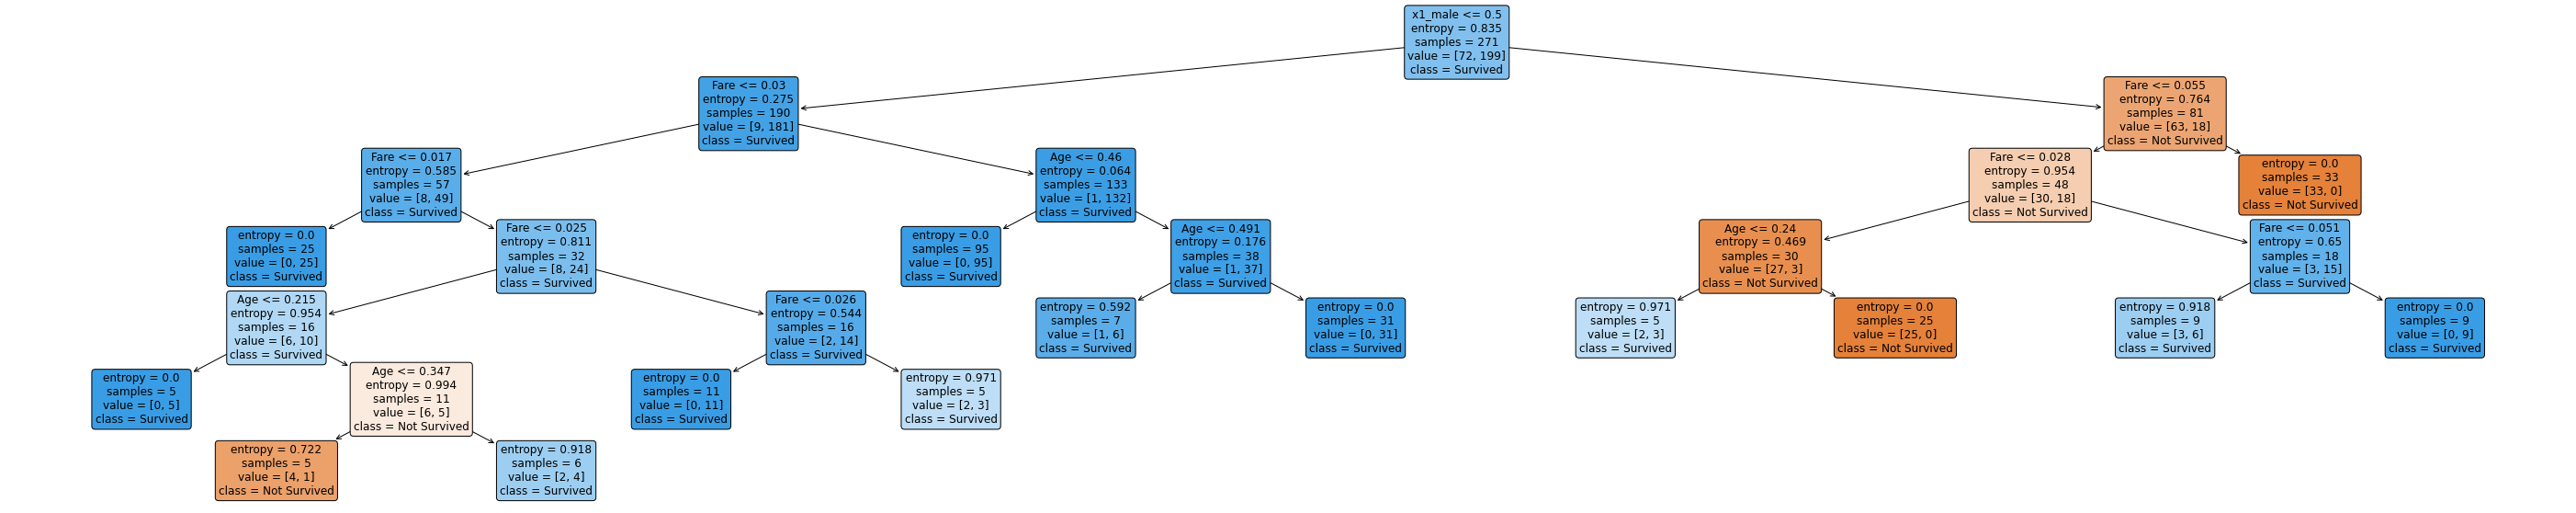

In [76]:
tree_error = DecisionTreeClassifier()
_ = tree_pipeline.fit(X_train_errors.drop(columns=['preds', 'true']), X_train_errors['preds'])

cat_enc_col = (
    tree_pipeline
    .named_steps['preprocess']
    .transformers_[1][1]
    .named_steps['one-hot']
    .get_feature_names_out()
    .tolist()
    )
name_new_col = (
    tree_pipeline
    .named_steps['preprocess']
    .transformers_[2][1]
    .get_feature_names_out()
    .tolist()
    )

preprocess_col = num_col + cat_enc_col + name_new_col
selected_cols_pos = tree_pipeline.named_steps['feature_selection'].get_feature_names_out()
feature_names = [preprocess_col[int(col_name.replace('x',''))] for col_name in selected_cols_pos]

plt.figure(figsize=(50, 10))
plot_tree(
    tree_pipeline['model'],
    filled=True, 
    rounded=True, 
    feature_names=feature_names, 
    class_names=['Not Survived', 'Survived']
    );

We already know that all this observations should be predicted as Suvived, the question is to understand which are the factors that leads our decision tree to label them as Not Survived. Here we can see the main factors: 

* When you are a male and you paid a high fare
* When you are a male and your paid a really low fare but your are old

# 11th iteration: KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
    ('model', KNeighborsClassifier())
])

from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_neighbors': range(1, 10),
    'model__weights': ['uniform', 'distance'],
    'model__p': [1,2]
    }
search = GridSearchCV(
    knn_pipeline, 
    param_grid,
    cv=15, 
    scoring='accuracy',
    verbose=1,
    refit=True, 
    n_jobs=-1
    )

_ = search.fit(X_train, y_train)

Fitting 15 folds for each of 36 candidates, totalling 540 fits


In [78]:
accuracy_score(search.predict(X_train), y_train)

0.8455056179775281

In [79]:
acc_11th = accuracy_score(search.predict(X_test), y_test)
acc_11th

0.8100558659217877

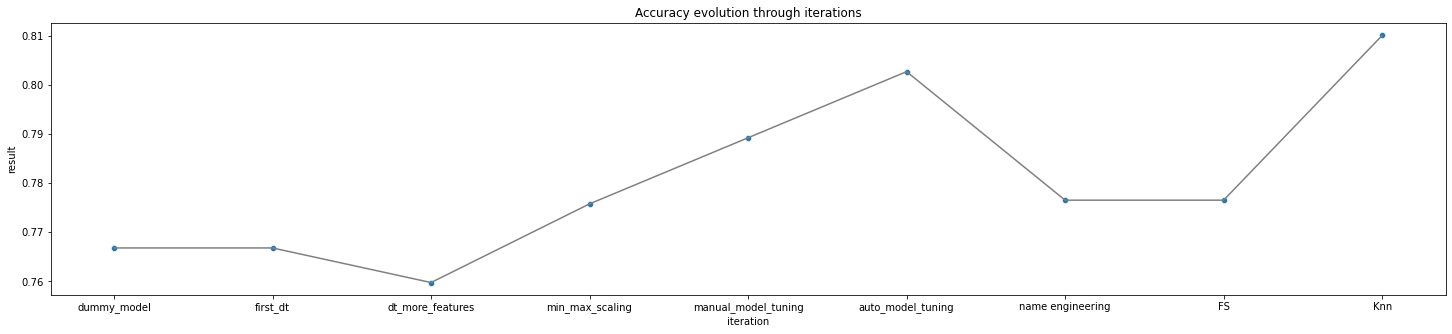

In [80]:
plot_iterations_evolution('Knn', acc_11th)